In [29]:
import os
import time
import torch
import torch.nn as nn
from torch.distributed.fsdp.wrap import transformer_auto_wrap_policy
from torch.utils.data import DataLoader
from torch.utils.data.distributed import DistributedSampler
from functools import partial
import hydra
from omegaconf import DictConfig, OmegaConf


from model.tokenizer import (CausalTokenizerDecoder, 
                             CausalTokenizerEncoder, 
                             CausalTokenizerConfig, 
                             TokensToImageHead, 
                             ImagePatchifier)
from model.blocks import EfficientTransformerLayer
from model.utils import TokenMasker

from dataset import ShardedHDF5Dataset, SingleViewSequenceDataset

class ModelWrapper(nn.Module):
    def __init__(self, cfg:DictConfig):
        super().__init__()
        self.cfg = cfg
        tokenizer_cfg = CausalTokenizerConfig(**OmegaConf.to_object(cfg.tokenizer)) 
        self.encoder = CausalTokenizerEncoder(tokenizer_cfg)
        self.decoder = CausalTokenizerDecoder(tokenizer_cfg)
        self.patchifier = ImagePatchifier(cfg.tokenizer.patch_size, cfg.tokenizer.model_dim)
        self.image_head = TokensToImageHead(cfg.tokenizer.model_dim, cfg.dataset.resolution, cfg.tokenizer.patch_size)
        self.masker = TokenMasker(cfg.tokenizer.model_dim, cfg.tokenizer.num_modality_tokens)

    def forward(self, images):
        images = (images*2.)-1. # Translate the images in +-1 range
        tokens = self.patchifier(images)
        masked_tokens = self.masker(tokens)
        z, _ = self.encoder(masked_tokens)
        z_decoded = self.decoder(z)
        recon_images = self.image_head(z_decoded)
        return  torch.clamp((recon_images + 1)/2., 0., 1.)

In [30]:
from hydra import initialize, compose
with initialize(config_path="config"):
    cfg = compose('tokenizer_cfg2.yaml')
model = ModelWrapper(cfg)

/tmp/ipykernel_426433/977884467.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  with initialize(config_path="config"):
/home/mim-server/miniconda3/envs/dreamerv4/lib/python3.11/site-packages/hydra/_internal/defaults_list.py:251: UserWarning: In 'tokenizer_cfg2.yaml': Defaults list is missing `_self_`. See https://hydra.cc/docs/1.2/upgrades/1.0_to_1.1/default_composition_order for more information
  warnings.warn(msg, UserWarning)


In [31]:
import torch
state_dict = torch.load("/home/mim-server/dreamer-v4/tokenizer_ckpts/soar-tokenizer-cfg2/1.pt")
# state_dict = torch.load("/home/mim-server/dreamer-v4/tokenizer_ckpts/pusht_tokenizer_small.pt")
sd = state_dict['model']

# Clean the keys (remove `_orig_mod.`)
clean_sd = {}
for k, v in sd.items():
    new_k = k.replace("_orig_mod.", "")
    clean_sd[new_k] = v

In [32]:
num_params = sum(p.numel() for p in model.encoder.parameters() if p.requires_grad)
print(f"Number of encoder parameters (M): {num_params/1e6:.2f}M")
num_params = sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)
print(f"Number of decoder parameters (M): {num_params/1e6:.2f}M")

Number of encoder parameters (M): 201.87M
Number of decoder parameters (M): 201.61M


In [33]:
model.load_state_dict(clean_sd)
model = model.cuda()
model = model.eval()

In [34]:
dataset = ShardedHDF5Dataset(
    data_dir="/home/mim-server/soar_data_sharded/soar_data_sharded",
    window_size=96,
    stride=1,
    split="train",
    train_fraction=0.9,
    split_seed=123,
)   

pusht_dataset = SingleViewSequenceDataset("/home/mim-server/datasets/pushT/128/episode_0.h5", 31, load_to_ram=False)

Train split: 350119 windows from 27276 episodes


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.1171875..1.203125].


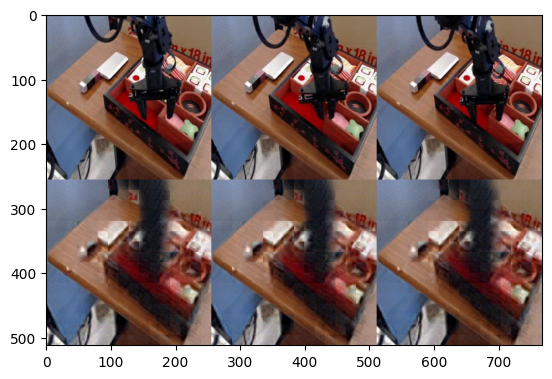

In [36]:
from torch.nn.functional import interpolate

imgs = dataset[1500]['image'].cuda()
# imgs = pusht_dataset[10]['observation.image'].cuda()
imgs = interpolate(imgs, (256,256))
imgs=imgs[None]
signal = 1.
with torch.no_grad():
    with torch.autocast(device_type="cuda", dtype=torch.bfloat16):
        patches = model.patchifier((imgs*2.)-1.)
        latents, _ = model.encoder(patches)
        latents = signal*latents + (1-signal)*torch.randn_like(latents).cuda()
        z_decoded = model.decoder(latents)
        imgs_recon = model.image_head(z_decoded)
        imgs_recon = (imgs_recon + 1)/2.

import matplotlib.pyplot as plt
vis_imgs = torch.concat([imgs, imgs_recon], dim=-2).squeeze().cpu()
time_idx = [i*5 for i in range(3)]
plt.imshow(torch.concat([vis_imgs[idx] for idx in time_idx], dim=-1).permute(1,2,0))
from torchvision.utils import save_image
save_image(torch.concat([vis_imgs[idx] for idx in time_idx], dim=-1), 'vis.png')

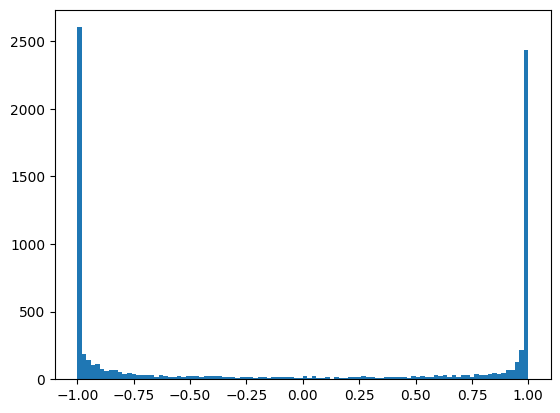

In [17]:
_ = plt.hist(latents[0,0].view(-1).cpu().to(torch.float32), bins=100)


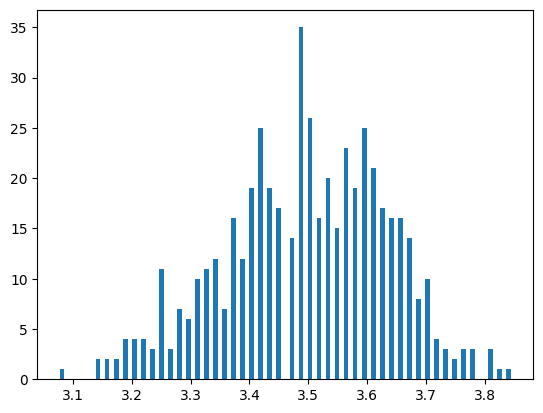

In [133]:

_ = plt.hist(latents[0,0].norm(dim=-1).cpu().to(torch.float32).squeeze(), bins=100)


In [132]:
latents[0,0].norm(dim=-1).shape

torch.Size([512])

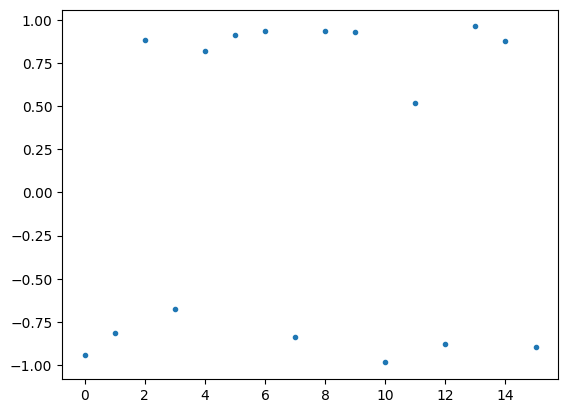

In [140]:
plt.plot(latents[0,0,4].cpu().to(torch.float32), '.')

In [29]:
from model.utils import TokenMasker
masker = TokenMasker(1024, 0.9, activate_masking=False).cuda()

_, mask = masker(patches)

mask = mask.view(1, 96, 16,16)[0]

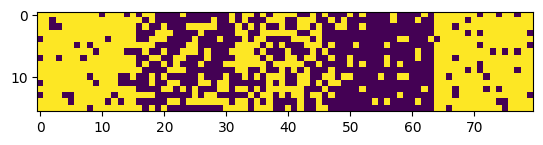

In [34]:
plt.imshow(torch.concat([mask[0], mask[5], mask[10], mask[15], mask[20]], dim=-1).cpu())

In [2]:
from model.dynamics import ForwardDiffusionWithShortcut
df = ForwardDiffusionWithShortcut(128)

In [6]:
B, T, N, D = (1, 96, 512, 16)
x = torch.zeros(B, T, N, D)
x_noise = df(x)
x_noise.keys()

dict_keys(['x_tau', 'tau_d', 'step_d', 'tau_plus_half_d', 'half_step_d', 'tau', 'step'])

In [9]:
x_noise['step']

tensor([[0.5000, 0.0078, 1.0000, 1.0000, 0.0078, 1.0000, 0.2500, 0.0156, 0.0156,
         0.0625, 0.0078, 0.5000, 0.0156, 0.2500, 0.0078, 0.2500, 0.0625, 0.0156,
         1.0000, 0.2500, 0.5000, 0.0625, 0.0625, 0.0312, 0.0625, 0.2500, 0.0078,
         0.0625, 0.5000, 1.0000, 0.0312, 0.2500, 0.0156, 0.5000, 0.0156, 0.1250,
         0.0312, 0.0312, 0.0156, 0.0156, 0.0156, 0.1250, 0.1250, 0.1250, 1.0000,
         0.0078, 0.0625, 1.0000, 1.0000, 0.2500, 0.5000, 0.0625, 0.0078, 1.0000,
         0.5000, 1.0000, 1.0000, 0.0078, 0.2500, 0.0156, 0.5000, 0.0156, 0.5000,
         0.2500, 0.5000, 0.1250, 0.0625, 0.0312, 0.1250, 0.1250, 0.0078, 1.0000,
         1.0000, 0.0156, 0.2500, 0.0078, 0.0312, 0.0156, 0.1250, 0.5000, 0.5000,
         0.0312, 0.1250, 0.0625, 0.0078, 0.0625, 0.5000, 0.1250, 0.5000, 0.0312,
         0.0156, 0.1250, 0.5000, 0.5000, 0.0078, 0.2500]])

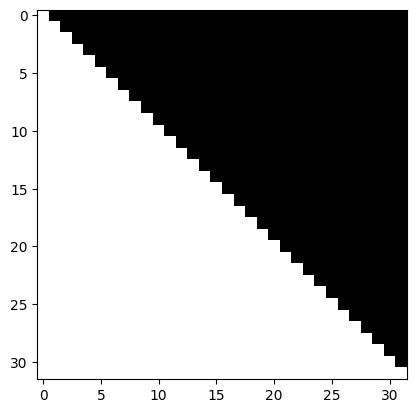

In [28]:
from model.utils import create_temporal_mask, create_decoder_spatial_mask, create_encoder_spatial_mask

def create_temporal_mask(T: int, device: str = "cpu") -> torch.Tensor:
    """
    Standard causal mask for attention:
      mask[q, k] = True  -> allowed (k <= q)
      mask[q, k] = False -> masked out (k > q)
    Shape: (T, T)
    """
    # Lower-triangular (including diagonal) is True
    arange = torch.arange(T, device=device)
    mask = arange.view(T, 1) >= arange.view(1, T)  # (q >= k)
    return mask  # dtype=bool, shape (T, T)


mask = create_temporal_mask(32)
enc_mask = create_encoder_spatial_mask(256, 32)
dec_mask = create_decoder_spatial_mask(256, 32)
plt.imshow(mask, cmap='gray')
plt.imshow(mask,  cmap='gray')